## ** To be integrated with other notebook?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
np.random.seed(42)

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [4]:
cell1_id = 517417584

cell2_id = 517417136
# another good (negatively correlated second choice)
# cell2_id = 517417337
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

## Calculate all mean responses

In [5]:
# import pandas as pd

# timestamps, dff = data_set.get_dff_traces()
# stim_table = data_set.get_stimulus_table("drifting_gratings")
# stim_table = stim_table[stim_table['blank_sweep']==False]

# all_cells_index = range(dff.shape[0])
# mean_sweep_response = pd.DataFrame(index=stim_table.index, columns=all_cells_index)

# # now fill this dataframe with trial averaged responses from dff
# # you'll need to loop over trials, but try not to loop over cells!
# for trial in stim_table.index:
#     mean_sweep_response.loc[trial, :] = dff[
#         :, stim_table.loc[trial, "start"] : stim_table.loc[trial, "end"]
#     ].mean(axis=1)

# # then normalize the data by cell
# mean_sweep_response = (mean_sweep_response - mean_sweep_response.mean(axis=1)) / mean_sweep_response.std(axis=1)
# mean_sweep_response = mean_sweep_response.dropna(axis=1)

In [6]:
# TODO: discuss how different from above!
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
dg = DriftingGratings(data_set)

mean_sweep_response = dg.mean_sweep_response
mean_sweep_response = mean_sweep_response.drop(columns=['dx'])
mean_sweep_response.columns = mean_sweep_response.columns.astype(int)

stim_table = dg.stim_table
mean_sweep_response = mean_sweep_response[stim_table['blank_sweep'] == False]
stim_table = stim_table[stim_table['blank_sweep'] == False]

To understand the responses of the *population* of cells in this session, we'll first simplify things by isolating the stimuli for a particular temporal frequency.

In [7]:
# Ex:
# Use the information in the stimulus table to select a subset of responses at a particular temporal frequency

selected_sweeps = (stim_table['temporal_frequency'] == 2.0)
selected_responses = mean_sweep_response[selected_sweeps]

## Fitting and prediction in scikit-learn

We are going to use some basic machine learning to solve a *classification* problem based on this data: given the responses of a set of cells on a given trial, can we predict the stimulus orientation of that trial? 

We'll use the package scikit-learn (sklearn), which is a popular and powerful machine learning package in Python. One strength of this package is a simple interface (pattern of use) for a variety of different machine learning tools, or *estimators*. It follows an *object-oriented* approach - each estimator is a Python class which must first be initialized, then passed data to fit and make predictions from.

This pattern can be used for different types of problems: *classification* when the target is categorical, *regression* when the target is continuous, or even *unsupervised* problems where there is no target data to train on. Chains of estimators can even be combined into *pipelines* that can be used in the same way. 

We typically represent the data feature matrix by a variable `X` (capital to indicate a 2D matrix, with each column a distinct feature and each row a sample) and the target data by a variable `y` (lowercase to indicate a 1D vector). In terms of these variables, the key methods of an estimator model in sklearn are `model.fit(X, y)` and `model.predict(X)`.

We'll start by returning to a *binary classification*, predicting whether the orientation matches a single target orientation, and include only a single cell in our feature matrix.

In [8]:
# First define X and y
cells = data_set.get_cell_specimen_indices([cell1_id, cell2_id])
target_orientation = 45
cells_index = [cells[0]]
# Create a binary indicator for our selected orientation
y = (stim_table.loc[selected_sweeps, 'orientation'] == target_orientation).astype(int)
X = selected_responses.loc[:, cells_index]
X.shape

(119, 1)

In [9]:
from sklearn.linear_model import LogisticRegression
# Create an instance of the Logistic Regression model
model = LogisticRegression(class_weight="balanced", C=1e6)

# Fit the model
model.fit(X, y)

# Predict the target variable 
y_pred = model.predict(X)

In [10]:
# Ex:
# Calculate the accuracy of the model (on what percent of trials does the prediction match the target)
accuracy = (y == y_pred).mean()
print(accuracy)

0.773109243697479


## Visualizing the model predictions

The classifier we chose has the advantage of a fairly simple mathematical formulation, allowing us to interpret how it makes its predictions. It is a *linear* classifier, meaning the classifier predicts "true" if $C + k \cdot x > 0$ and "false" otherwise, defining a dividing line to split the input space into true and false samples. We can plot this line using properties of the fitted classifier.

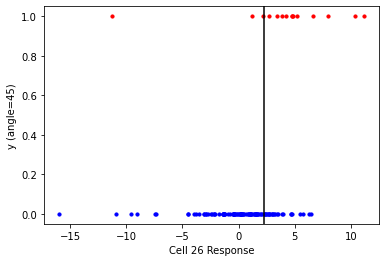

In [11]:
# first create a scatter plot of the cell's responses colored by y
# with 'true' responses in red and 'false' in blue
cell1_responses = selected_responses.loc[:, cells_index[0]]
target_trials = y.astype(bool)
plt.scatter(cell1_responses[target_trials], y[target_trials], s=10, color='red', label=f"angle={target_orientation}")
plt.scatter(cell1_responses[~target_trials], y[~target_trials], s=10, color='blue', label="other angles")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f"y (angle={target_orientation})")

# pull the coefficient k and intercept C out of the classifier
k = model.coef_[0][0]
C = model.intercept_

# calculate the dividing line and plot with axvline
x_cutoff = -C / k
plt.axvline(x_cutoff, color='black')
plt.show()


### Logistic regression and probabilities
The parameters of this line are determined by optimizing a probabilistic model of the data, $\mathrm{Pr}(y) = f(C + k_0 \cdot x_0 + k_1 \cdot x_1 + \dots)$, where $f$ is the *logistic function* shown in the plot below, $f(x) = \frac{1}{1-e^{-x}}$:

![logistic curve](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

We can check these probabilities for any point in our input space using the function `model.predict_proba(X)`. We can then add probabilities to our two-cell response plot also.

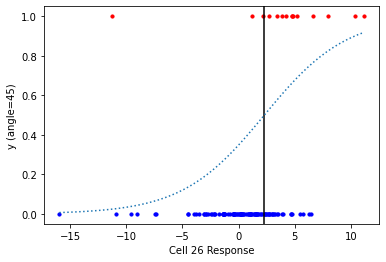

In [12]:

plt.scatter(cell1_responses[target_trials], y[target_trials], s=10, color='red', label=f"angle={target_orientation}")
plt.scatter(cell1_responses[~target_trials], y[~target_trials], s=10, color='blue', label="other angles")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f"y (angle={target_orientation})")

plt.axvline(x_cutoff, color='black')

# use predict_proba to add a plot of the probabilities for a range of x-values
n = 50
xx = np.linspace(cell1_responses.min(), cell1_responses.max(), n)
probs = model.predict_proba(xx[:,None])[:, 1]
plt.plot(xx, probs, ':')

plt.show()

### Classification in 2 dimensions

We can add a second cell and fit as before, then visualize this case also, in two dimensions.

In [13]:
# redefine X to include both cells
cells_index = cells
X = selected_responses.loc[:, cells_index]

# Fit the model
model.fit(X, y)
model.score(X, y)

0.8739495798319328

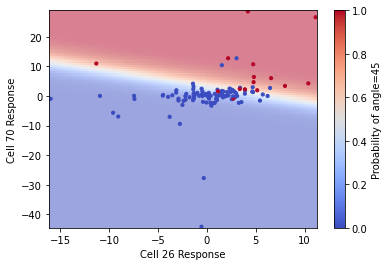

In [14]:
# There is a built-in function to visualize the classifier boundary and probabilities
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="pcolormesh",
    response_method="predict_proba",
    ax=plt.gca(),
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    alpha=0.5,
    shading="auto",
    eps=0.01,
)

cell1_responses = selected_responses.loc[:, cells_index[0]]
cell2_responses = selected_responses.loc[:, cells_index[1]]
plt.scatter(cell1_responses, cell2_responses, s=10, c=y, cmap="coolwarm")
plt.xlabel(f"Cell {cells_index[0]} Response")
plt.ylabel(f"Cell {cells_index[1]} Response")

plt.colorbar(label=f"Probability of angle={target_orientation}")
plt.show()

### 2D Visualization details

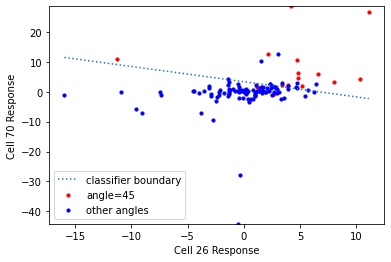

In [15]:
# first create a scatter plot of the two cells' responses colored by y
# with 'true' responses in red and 'false' in blue
cell1_responses = selected_responses.loc[:, cells_index[0]]
cell2_responses = selected_responses.loc[:, cells_index[1]]
target_trials = y.astype(bool)
plt.scatter(cell1_responses[target_trials], cell2_responses[target_trials], s=10, color='red', label=f"angle={target_orientation}")
plt.scatter(cell1_responses[~target_trials], cell2_responses[~target_trials], s=10, color='blue', label="other angles")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f'Cell {cells_index[1]} Response')


# pull the coefficient parameters k out of the classifier
k = model.coef_[0]
C = model.intercept_

# pick evenly spaced x-values to plot the classifier boundary line
n = 10
x_line = np.linspace(cell1_responses.min(), cell1_responses.max(), n)

# calculate the y-values of the classifier boundary line using the equation above
y_line = (-C - k[0] * x_line) / k[1]
plt.plot(x_line, y_line, ':', label="classifier boundary")

# adjust the plot bounds with plt.ylim
plt.ylim(cell2_responses.min(), cell2_responses.max())

plt.legend()
plt.show()

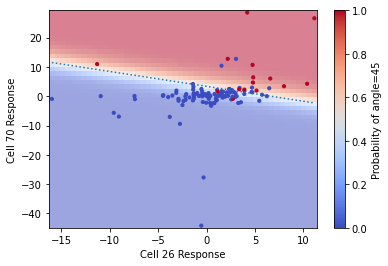

In [16]:
# the coolwarm colormap is nice for probabilities, mapping values between 0 and 1 to colors from blue to red
cmap = plt.cm.coolwarm
# we can use this colormap to color our response scatterplot by the binary targets y

# pass evenly spaced x and y coordinates to np.meshgrid to create a grid
n = 50
xx = np.linspace(cell1_responses.min(), cell1_responses.max(), n)
yy = np.linspace(cell2_responses.min(), cell2_responses.max(), n)
xgrid, ygrid = np.meshgrid(xx, yy)

# flatten and stack these lists to create a X matrix to pass to model.predict_proba
Xgrid = np.vstack([xgrid.flatten(), ygrid.flatten()]).T
probs = model.predict_proba(Xgrid)[:, 1]

# reshape the probabilities to fit the shape of the grid
probs_grid = probs.reshape(n, n)
plt.pcolormesh(xgrid, ygrid, probs_grid, cmap=cmap, alpha=0.5, shading='auto')

# finally, copy the code for our response scatter plot to overlay it here
plt.scatter(cell1_responses, cell2_responses, s=10, c=y, cmap='coolwarm')
plt.plot(x_line, y_line, ':', label="classifier boundary")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f'Cell {cells_index[1]} Response')

# and add a colorbar for the probabilities
plt.colorbar(label=f'Probability of angle={target_orientation}')
plt.show()

### Exercise: training with "class imbalance"
**TODO: reword this if keeping**

You might notice that the plots above have quite a few false negatives (red points on the wrong side of the boundary) - this is because it was trained with many more 'false' samples than 'true' samples. One way to fix this is creating the classifier with the option `LogisticRegression(class_weight='balanced')`. Try rerunning the above cells with this option.

## Predicting all orientations

We can also use the `LogisticRegression` classifier to predict which of the 8 orientations a response comes from. This involves a mathematical model for the probability of each class/orientation, which are then compared for a final prediction. Scikit-learn makes this very easy, adapting the model to do this in the background if we simply pass a *categorical* rather than *binary* target variable `y`.

In [17]:
# Ex: 
# redefine y to include all orientations, fit, and find the model accuracy score
# Hint: you can actually use the column directly from the dataframe (or convert to an array)
X = selected_responses.loc[:, cells_index]
y = stim_table.loc[selected_sweeps, 'orientation']
model.fit(X, y)
model.score(X, y)

0.2689075630252101

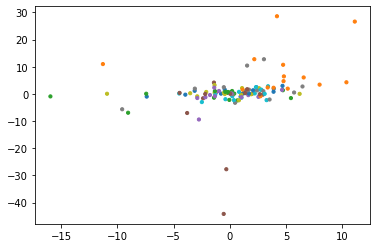

In [18]:
# TODO: used to assess cell choices - keep or remove?
plt.scatter(*X.values.T, s=10, c=y, cmap='tab10')
plt.show()

This is not very good, as expected - two cells can only tell us so much. However, sklearn makes it very easy to train on all recorded cells in the session together!

In [19]:
# Ex: 
# redefine X to include all cells, fit, and find the model accuracy score
X = selected_responses
y = stim_table.loc[selected_sweeps, 'orientation']
# We need to adjust the model here for this more complex setting
model = LogisticRegression(max_iter=10000)

model.fit(X, y)
model.score(X, y)

1.0

Discuss: Does anything seem odd to you about this result? Let's discuss why this may not be as perfect as it seems.

## Splitting training and test data

Our ultimate goal is a model that captures **true** patterns in the data, but what does "true" mean here? One way of resolving this scientifically would be to experiment: generate more data from the same cells and see if the same patterns are present (if the estimator can predict the stimuli well on the new data). Practically, we can't usually repeat experiments like this, but we can instead hide some of the existing data during the *fit* step and use it only to predict and evaluate. We call the fit data the training dataset, and the hidden data the test dataset.

Sklearn has a method to shuffle the data (across trials) and make this split randomly `train_test_split`.

Discuss: Why might shuffling be important here?

In [20]:
# this introduces randomness, so set the random 'seed' for reproducibility
np.random.seed(5)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)


In [22]:
# Ex:
# Fit the model on the training data, predict the binary indicator for the test data, and calculate the accuracy
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.7

## Viewing the confusion matrix

Let's also visualize a confusion matrix of the pattern of errors. Sklearn has a built-in method for this - try out the function `sklearn.metrics.ConfusionMatrixDisplay.from_estimator()`

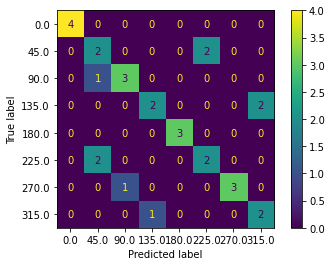

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### Fitting with all temporal frequencies

It's hard to tell if there is a pattern in the above confusion matrix because there are not many trials to plot in our test set. Let's try adding back in the other trials.

In [24]:
X = mean_sweep_response
y = stim_table['orientation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

model.fit(X_train, y_train)
model.score(X_test, y_test)


0.68

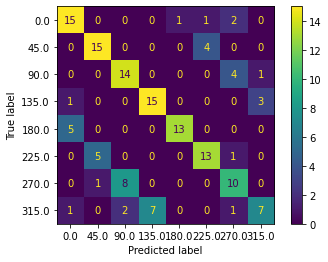

In [25]:
cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test , normalize=None)

In this case, decoding performance is similar, perhaps slightly worse when we include all temporal frequencies. However, the larger test set lets us begin to see a clear pattern to the errors in the confusion matrix plot.

Discuss: what do you think this pattern means?

### REMOVE: check comparison w/ cross validation

In [26]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True)
# all sweeps
X = mean_sweep_response
y = stim_table['orientation']
cross_val_score(model, X, y, cv=cv).mean()

0.754187675070028

In [27]:
# good TF sweeps
X = mean_sweep_response[selected_sweeps]
y = stim_table.loc[selected_sweeps, 'orientation']
cross_val_score(model, X, y, cv=cv).mean()

0.7478260869565216

## Classifier for both TF & orientation

We've seen that decoding can do fairly well with all the data, not knowing about the temporal frequency at all. Is it possible we could increase performance even more by training on both orientation and temporal frequency labels together? A few classifiers in sklearn can function in the *multi-output* context where we pass a 2D matrix of target data instead of a vector. We'll test out one of these, the random forest classifier.

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Ex: Define the target variable and the feature matrix, and run the train_test_split function
X = mean_sweep_response
Y = stim_table[['temporal_frequency', 'orientation']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Ex: Create an instance of the Random Forest model, fit the model, and predict the target variable
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [29]:
# we can't use model.score in this context, so instead generate a prediction of the target variables,
# and evaluate accuracy separately each one, using the accuracy_score function
from sklearn.metrics import accuracy_score

print("temporal frequency accuracy: ", accuracy_score(y_test.values[:,0], y_pred[:,0]))
print("orientation accuracy: ", accuracy_score(y_test.values[:,1], y_pred[:,1]))

temporal frequency accuracy:  0.58
orientation accuracy:  0.74


This is similar to before, but is it actually better? How much does performance vary run to run? As implied in the name, the random forest classifier has an element of randomness in its performance.

We should also compare to the same classifier's performance on orientation data only.

In [30]:
# Ex: repeat the above process with orientation data only in Y
X = mean_sweep_response
Y = stim_table['orientation']
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)


model.fit(X_train, y_train)
model.score(X_test, y_test)


0.7733333333333333

## Extra: using cross-validation to get better estimates of accuracy

In [31]:
from sklearn.model_selection import cross_val_predict, KFold

cv = KFold(n_splits=5, shuffle=True)

# Ex: Calculate the cross-validated accuracy of the model
y_pred = cross_val_predict(model, X, Y, cv=cv)
print("accuracy: ", accuracy_score(Y, y_pred))

accuracy:  0.7575250836120402


In [32]:
Y = stim_table[['temporal_frequency', 'orientation']]

y_pred = cross_val_predict(model, X, Y, cv=cv)
print("temporal frequency accuracy: ", accuracy_score(Y.values[:,0], y_pred[:,0]))
print("orientation accuracy: ", accuracy_score(Y.values[:,1], y_pred[:,1]))

temporal frequency accuracy:  0.5501672240802675
orientation accuracy:  0.782608695652174


## Exercise: train a classifier on natural image responses

In [43]:
# find the dataset and stim table for natural scenes for the same cells
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['natural_scenes'])
session_id = exps[0]['id']
data_set_ns = boc.get_ophys_experiment_data(session_id)

stim_table_ns = data_set_ns.get_stimulus_table("natural_scenes")
stim_table_ns.head()

,frame,start,end
0,2,16098,16105
1,107,16106,16113
2,54,16114,16121
3,53,16121,16128
4,41,16129,16136


In [36]:
# how many times is each stimulus presented?
stim_table_ns["frame"].value_counts()

frame
2      50
108    50
3      50
96     50
85     50
       ..
11     50
22     50
45     50
94     50
44     50
Name: count, Length: 119, dtype: int64

In [55]:
# choose a handful of images and subset the stim table to just the relevant trials
images = [0, 13, 15, 18, 32]
images = [13, 15, 18]
sweeps = stim_table_ns[stim_table_ns["frame"].isin(images)]

In [75]:
# make your code from above into a function to calculate the mean sweep response
import pandas as pd
def get_mean_sweep_response(dff, stim_table):
    all_cells_index = range(dff.shape[0])
    mean_sweep_response = pd.DataFrame(index=stim_table.index, columns=all_cells_index)

    for trial in stim_table.index:
        mean_sweep_response.loc[trial, :] = dff[
            :, stim_table.loc[trial, "start"] : stim_table.loc[trial, "end"]
        ].mean(axis=1)
    # Normalize
    X = mean_sweep_response.values.astype(float)
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
    # from sklearn.preprocessing import scale
    # X = scale(X)
    return X

# then run it on the natural scenes data
timestamps, dff = data_set_ns.get_dff_traces()
response = get_mean_sweep_response(dff, sweeps)

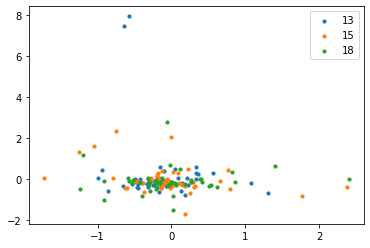

In [81]:
# define X and y for responses of the pair of cells,
# then plot the responses colored by the image frame
# the cell indices may be different in this new session/dataset
cells = data_set_ns.get_cell_specimen_indices([cell1_id, cell2_id])
# X = response[cells].values
X = response[:, cells]
y = sweeps["frame"]

for value in y.unique():
    subset = y == value
    plt.scatter(X[subset, 0], X[subset, 1], s=10, label=value)
plt.legend()
plt.show()


In [82]:
# define X and y for the population of cells, split train and test data,
# then fit and score a logistic regression classifier and plot the confusion matrix
X = response
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
model.score(X_test, y_test)
# model.score(X_train, y_train)


0.3684210526315789

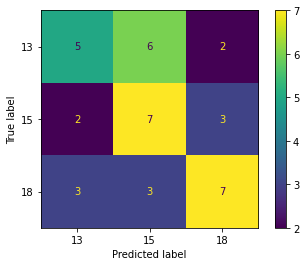

In [80]:
cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test , normalize=None)